In [3]:
import h5py
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
from matplotlib import animation
import pde
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error

from IPython.display import Video

In [4]:
x_s=2*np.sqrt(2)
d=0
mu=0.1

filename = f'./Data/Simulations/FP_dwa.h5'
data = h5py.File(filename)

t = np.array(data['times'][:10000])
t = t[:10000]
dt = t[1]-t[0]

x = np.array(data['x'])
dx = x[1]-x[0]

u = np.array(data['data'][:10000])
u = u[:10000]
u_dot = ps.FiniteDifference(axis=0)._differentiate(u, t=dt)

data.close()

In [3]:
prob = np.abs(u)

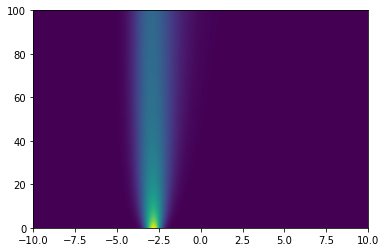

In [5]:
plt.pcolormesh(x, t, u)

In [79]:
# beta = 1/2

# avg_x = np.sum(prob*x, axis=1)*dx
# sigma_x = np.sqrt(np.sum(prob*x*x, axis=1)*dx - avg_x**2)

# avg_x_dot = ps.FiniteDifference(axis=0)._differentiate(avg_x, t=dt)
# sigma_x_dot = ps.FiniteDifference(axis=0)._differentiate(sigma_x, t=dt)

# eta = (beta**2/sigma_x**2)*(np.tile(x, (len(t),1)).T - avg_x)
# nu = avg_x_dot + (sigma_x*sigma_x_dot/beta**2)*eta

# nu_dot = ps.FiniteDifference(axis=0)._differentiate(nu, t=dt)

In [6]:
u_shaped = np.zeros(shape=(len(x), len(t), 2))
u_shaped[:,:, 0]=u.T
u_shaped[:,:, 1]=np.tile(x,(len(t),1)).T

u_dot_shaped = np.zeros(shape=(len(x), len(t), 1))
u_dot_shaped[:,:, 0] = u_dot.T




In [7]:
poly_library = ps.PolynomialLibrary(include_bias=False, degree=4) 

# PDE library
library_functions = [lambda x: x]
library_function_names = [lambda x: x]
pde_library = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=2, spatial_grid=x, 
                        include_bias=True, is_uniform=True, include_interaction=False)

# Tensor polynomial library with the PDE library
tensor_array = [[1, 1]]
inputs_temp = np.tile([0, 1], 2)
inputs_per_library = np.reshape(inputs_temp, (2, 2))
inputs_per_library[1,1] = 0 # only compute PDs for psi_real and psi_img
inputs_per_library[0] = [1, 1] # only compute polynomial for x input feature


generalized_library = ps.GeneralizedLibrary(
    [poly_library, pde_library],
    tensor_array=tensor_array,
    inputs_per_library=inputs_per_library,
)

In [8]:
## SET BEST THRESHOLD PARAMETER FOUND AND TRAIN USING ALL TRAINING SET ## 

optimizer = ps.STLSQ(threshold=0.00001, verbose=True)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer, feature_names=['rho', 'x'])
model.fit(u_shaped, t=dt)
model.print()

print(generalized_library.get_feature_names(), "\n")

 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 1.7552e-01 ... 7.3130e-06 ...         14 ... 1.7552e-01


C:\Users\loren\anaconda3\envs\sindy\lib\site-packages\pysindy\optimizers\stlsq.py:193: UserWarning: Sparsity parameter is too big (1e-05) and eliminated all coefficients
  warnings.warn(


         1 ... 1.7189e-01 ... 7.3866e-06 ...         13 ... 1.7189e-01


C:\Users\loren\anaconda3\envs\sindy\lib\site-packages\pysindy\optimizers\stlsq.py:193: UserWarning: Sparsity parameter is too big (1e-05) and eliminated all coefficients
  warnings.warn(


         2 ... 1.3579e-01 ... 7.7879e-06 ...         12 ... 1.3580e-01


C:\Users\loren\anaconda3\envs\sindy\lib\site-packages\pysindy\optimizers\stlsq.py:193: UserWarning: Sparsity parameter is too big (1e-05) and eliminated all coefficients
  warnings.warn(


         3 ... 1.3484e-01 ... 7.8023e-06 ...         12 ... 1.3485e-01
(rho)' = -0.005 rho + -0.001 rho_1 + 0.010 rho_11 + -0.005 x rho_1 + 0.002 x^2 rho + 0.001 x^3 rho_1
(x)' = 0.000
['x1', 'x1^2', 'x1^3', 'x1^4', '1', 'x0', 'x0_1', 'x0_11', 'x1 1', 'x1 x0', 'x1 x0_1', 'x1 x0_11', 'x1^2 1', 'x1^2 x0', 'x1^2 x0_1', 'x1^2 x0_11', 'x1^3 1', 'x1^3 x0', 'x1^3 x0_1', 'x1^3 x0_11', 'x1^4 1', 'x1^4 x0', 'x1^4 x0_1', 'x1^4 x0_11'] 



In [9]:
eq = model.equations(precision=6)[0]

In [10]:
eq

'-0.005202 rho + -0.001273 rho_1 + 0.009780 rho_11 + 0.000080 x rho + -0.005314 x rho_1 + -0.000158 x rho_11 + 0.001912 x^2 rho + 0.000117 x^2 rho_1 + -0.000011 x^2 rho_11 + 0.000012 x^3 rho + 0.000689 x^3 rho_1 + 0.000010 x^4 rho_1'

In [11]:
eq = eq.replace('rhorho', 'rho rho').replace('rho_11', 'laplace(rho)').replace('rho_1', 'd_dx(rho)').replace(' ', '*').replace('*+*', '+').replace('^','**')

In [12]:
eq

'-0.005202*rho+-0.001273*d_dx(rho)+0.009780*laplace(rho)+0.000080*x*rho+-0.005314*x*d_dx(rho)+-0.000158*x*laplace(rho)+0.001912*x**2*rho+0.000117*x**2*d_dx(rho)+-0.000011*x**2*laplace(rho)+0.000012*x**3*rho+0.000689*x**3*d_dx(rho)+0.000010*x**4*d_dx(rho)'

In [13]:
eqs = pde.PDE({'rho':eq})

Nx = len(x) # number of spatial points
x_left = x[0]
x_right = x[-1]

grid = pde.CartesianGrid([(x_left,x_right)], Nx, periodic=False)
grid.coordinate_arrays = (x,) # this is needed otherwise endpoints are excluded

initial_state = pde.ScalarField(grid, u[-1], label = '$rho$')

In [14]:
## PERFORM SIMULATION ##

# define storage 
storage = pde.MemoryStorage() # for movie and control plots

# simulation time and step (1e-6 and 1e-5 seems to work, more testing needed to se if less can be used)
t_range = 800 - t[-1]
dt_sim = 1e-2

N_t_anim = 1000 # this is enough do not change it 
dt_anim = t_range/N_t_anim


solver = pde.ExplicitSolver(eqs, scheme="runge-kutta", adaptive=False)
controller = pde.Controller(solver, t_range=t_range, tracker=['progress', storage.tracker(interval=dt_anim)])
_ = controller.run(initial_state, dt=dt_sim)


  0%|          | 0/699.9999999999858 [00:00<?, ?it/s]

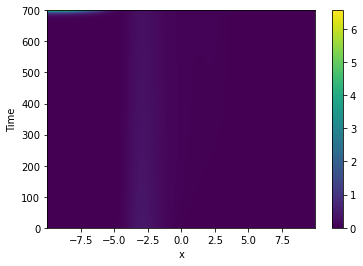

In [15]:
pde.plot_kymograph(storage)

In [16]:
# data_sim = np.array(storage.data)
# storage_sim = pde.MemoryStorage(times=t[-1]+np.array(storage.times), data=data_sim, field_obj=pde.ScalarField(grid, label='$rho_sim$', dtype=np.float64))

sindy_sim = np.array(storage.data)
times = t[-1]+np.array(storage.times)

In [17]:
filename = f'./Data/Simulations/FP_dwa.h5'
data = h5py.File(filename)

t = np.array(data['times'][10000:80000])
#t = t[10000:80000]
dt = t[1]-t[0]

x = np.array(data['x'])
dx = x[1]-x[0]

u = np.array(data['data'][10000:80000])
#u = u[10000:80000]
u_dot = ps.FiniteDifference(axis=0)._differentiate(u, t=dt)

data.close()

array([100.01, 100.02, 100.03, ..., 799.98, 799.99, 800.  ])

In [18]:
t = t[::70]
u = u[::70]


In [19]:
times = times[:-1]
sindy_sim = sindy_sim[:-1]

array([100.01, 100.02, 100.03, ..., 799.98, 799.99, 800.  ])

In [20]:
plt.style.use('seaborn-darkgrid')

In [21]:
from tqdm.notebook import tqdm

def my_pbar(curr_frame, tot_frame):
    pbar.update(100*curr_frame/tot_frame)

In [22]:
%matplotlib nbagg



fig,ax = plt.subplots(figsize=(8,4.5))

ax.set_xlabel('x')
ax.set_ylabel('a.u.')
# ax.axis('tight')
title = ax.set_title('Time = 0.000', y=1.05)
line1, = ax.plot(x, sindy_sim[0], "k--", label=r"$\rho_{sim}$")
line2, = ax.plot(x, np.abs(u[0]), color="navy", label=r"$\rho$")
plt.legend(loc=1, fontsize=8, fancybox=False)
plt.ylim(-0.05, 1)
plt.tight_layout()


def init():
    return line1, line2


def animate(i):
    # ax.set_facecolor('white')
    line1.set_data(x, sindy_sim[i])
    line2.set_data(x, np.abs(u[i]))
    title.set_text('Time = {0:1.3f}'.format(t[i]))
    return line2


anim = animation.FuncAnimation(fig, animate, init_func=init, interval=1, blit=True, frames=np.arange(0, len(t)))

writer = animation.FFMpegWriter(fps=30, bitrate=-1)


print("Generating animation ...")
pbar = tqdm(total=(len(t)-1)*50) # why times 50 works?
anim.save('./Images/sindy_asym.mov', writer=writer, dpi=150, progress_callback=my_pbar)
pbar.close()
print("Done")

# reset backend to inline
%matplotlib inline

<IPython.core.display.Javascript object>

Generating animation ...


  0%|          | 0/49950 [00:00<?, ?it/s]

Done


In [23]:
Video('./Images/sindy_asym.mov')